In [4]:
import matplotlib.pylab as plt
import numpy as np
import seaborn as sns; sns.set()
%matplotlib inline

import keras
from keras import objectives
from keras.callbacks import EarlyStopping
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, Multiply, Add
from keras.optimizers import Adam, Nadam
import salty
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from random import shuffle
import pandas as pd
import random

#Keras build
from keras import backend as K
from keras.objectives import binary_crossentropy #objs or losses
from keras.models import Model
from keras.layers import Input, Dense, Lambda, Layer
from keras.layers.core import Dense, Activation, Flatten, RepeatVector
from keras.layers.wrappers import TimeDistributed
from keras.layers.recurrent import GRU
from keras.layers.convolutional import Convolution1D

#cation data
cations = pd.read_csv('../data/cations.csv')
cations = cations['smiles_string']
salts = pd.read_csv('../data/salts.csv')
salts = salts['smiles_string']
categories = pd.read_csv('../data/categories.csv')
categories = categories['category']
coldic = pd.read_csv('../data/coldic.csv')
coldic = coldic.to_dict(orient='records')[0]
salt_coldic = pd.read_csv('../data/salt_coldic.csv')
salt_coldic = salt_coldic.to_dict(orient='records')[0]
salt_categories = pd.read_csv('../data/salt_categories.csv')
salt_categories = salt_categories['category']
density_coldic = pd.read_csv('../data/density_coldic.csv')
density_coldic = density_coldic.to_dict(orient='records')[0]
density_categories = pd.read_csv('../data/density_categories.csv')
density_categories = density_categories['category']

#supporting functions
import sys
sys.path.insert(0, '../')
from scripts import *

In [5]:
#training array info
smile_max_length = 105
import json
f = open("../data/salt_char_to_index.json","r")
char_to_index = json.loads(f.read())
char_set = set(char_to_index.keys())
char_list = list(char_to_index.keys())
chars_in_dict = len(char_list)

# Density

In [6]:
properties = ['density']
T = [297, 316] # select state variable ranges according to manuscript
P = [99, 102] # we will set MD simulation to 101 kPa and 298 K
props = properties
devmodel = salty.aggregate_data(props, T=T, P=P, merge='Union')
devmodel.Data['smiles_string'] = devmodel.Data['smiles-cation'] + "." + devmodel.Data['smiles-anion']
salts = devmodel.Data['smiles_string']
salts = salts.reset_index(drop=True)
print(salts.shape)

(5631,)


In [7]:
values = salts
print(values[0])
print(values.iloc[-1])
print(len(values))
padded_smiles =  [pad_smiles(i, smile_max_length) for i in values if pad_smiles(i, smile_max_length)]
X_train = np.zeros((values.shape[0], smile_max_length, chars_in_dict), dtype=np.float32)
Y_train = np.array(devmodel.Data['Specific density, kg/m<SUP>3</SUP>'])
for i, smile in enumerate(padded_smiles):
    for j, char in enumerate(smile):
        X_train[i, j, char_to_index[char]] = 1

CCCC[n+]1ccc(cc1)C.[B-](F)(F)(F)F
C1=C[N+](CCCC)=CN1C.C(C(F)(F)F)(C(F)(F)S(=O)(=O)[O-])F
5631


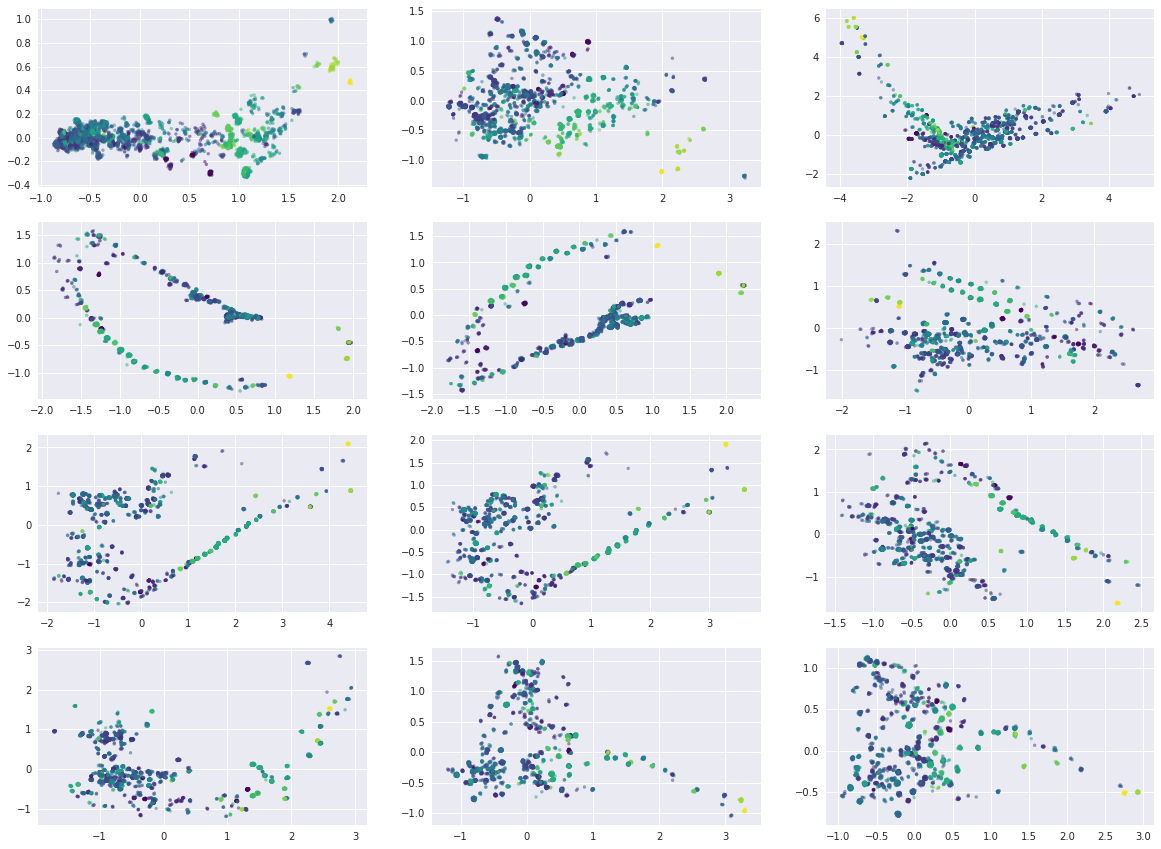

In [8]:
#figure
fig, axs = plt.subplots(4,3, figsize=(20,15))
axs = axs.ravel()

latent_embeddings= np.load('density_latent_embeddings.npy')
index = 0
for model in range(12):
    z = latent_embeddings[index, :, :]
    pca = PCA(n_components=2)
    pcs = pca.fit_transform(z)
           
    axs[index].scatter(pcs[:, 0], pcs[:, 1], c=np.exp(Y_train),
            alpha=.5, s=3**2, cmap='viridis')
    index += 1

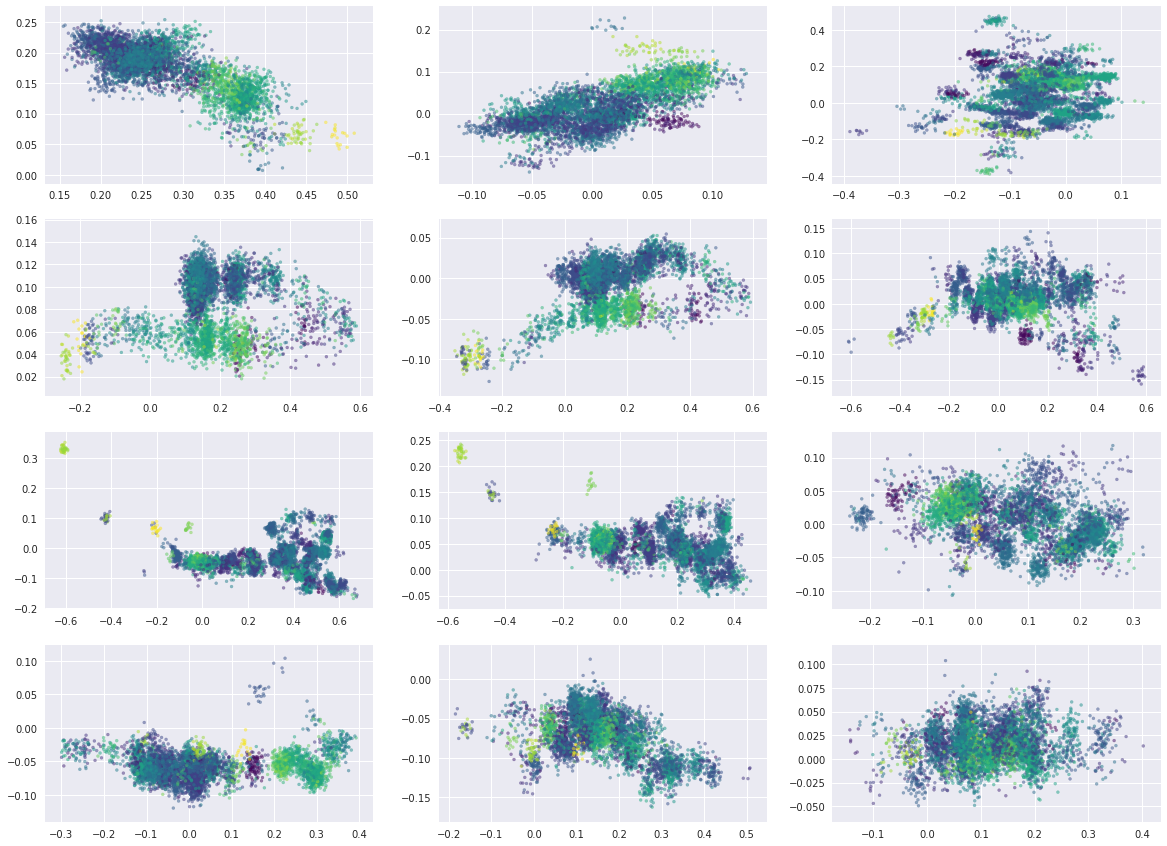

In [9]:
#figure
fig, axs = plt.subplots(4,3, figsize=(20,15))
axs = axs.ravel()

latent_embeddings= np.load('density_latent_embeddings.npy')
index = 0
for model in range(12):
    z = latent_embeddings[index, :, :]
    pca = PCA(n_components=2)
    pcs = pca.fit_transform(z)
    axs[index].scatter(z[:, 0], z[:, 1], c=np.exp(Y_train),
            alpha=.5, s=3**2, cmap='viridis')
    index += 1

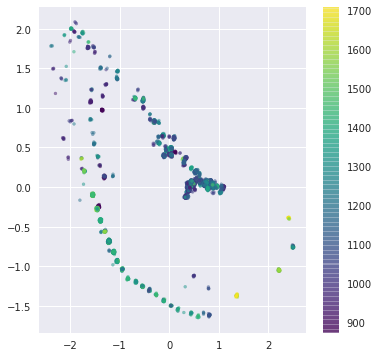

In [10]:
# display a 2D plot of the digit classes in the latent space
#training data
chemvae = MoleculeVAE()
name = 'gen2_2mol_50mil_GDB17_5_2.h5'
chemvae.create(char_set, max_length=smile_max_length, weights_file=name)

z_test = chemvae.encoder.predict(X_train)
pca = PCA(n_components=2)
pcs = pca.fit_transform(z_test)
plt.figure(figsize=(6, 6))
plt.scatter(pcs[:, 0], pcs[:, 1], c=np.exp(Y_train),
            alpha=.5, s=3**2, cmap='viridis')
plt.colorbar()
plt.show()

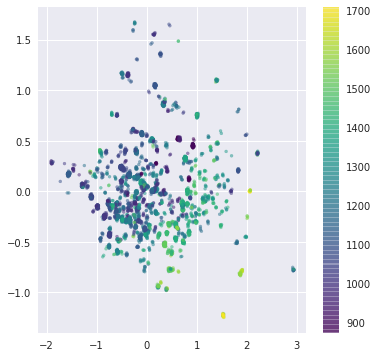

In [11]:
# display a 2D plot of the digit classes in the latent space
#training data
chemvae = MoleculeVAE()
name = 'gen2_2mol_50mil_GDB17_5_2_qspr_density_ATP_30_epoch.h5'
# name = 'gen3_2mol_qspr_density_ATP_10_epoch.h5'
chemvae.create(char_set, max_length=smile_max_length, weights_file=name)

z_test = chemvae.encoder.predict(X_train)
pca = PCA(n_components=2)
pcs = pca.fit_transform(z_test)
plt.figure(figsize=(6, 6))
plt.scatter(pcs[:, 0], pcs[:, 1], c=np.exp(Y_train),
            alpha=.5, s=3**2, cmap='viridis')
plt.colorbar()
plt.show()

# CPT Models

In [12]:
properties = ['cpt']
T = [297, 316] # select state variable ranges according to manuscript
P = [99, 102] # we will set MD simulation to 101 kPa and 298 K
props = properties
devmodel = salty.aggregate_data(props, T=T, P=P, merge='Union')
devmodel.Data['smiles_string'] = devmodel.Data['smiles-cation'] + "." + devmodel.Data['smiles-anion']
salts = devmodel.Data['smiles_string']
salts = salts.reset_index(drop=True)
print(salts.shape)

(1739,)


In [13]:
values = salts
print(values[0])
print(values.iloc[-1])
print(len(values))
padded_smiles =  [pad_smiles(i, smile_max_length) for i in values if pad_smiles(i, smile_max_length)]
X_train = np.zeros((values.shape[0], smile_max_length, chars_in_dict), dtype=np.float32)
Y_train = np.array(devmodel.Data['Heat capacity at constant pressure, J/K/mol'])
for i, smile in enumerate(padded_smiles):
    for j, char in enumerate(smile):
        X_train[i, j, char_to_index[char]] = 1

CCCC[n+]1ccc(cc1)C.[B-](F)(F)(F)F
CCCCn1cc[n+](c1)C.COCCOCCOS(=O)(=O)[O-]
1739


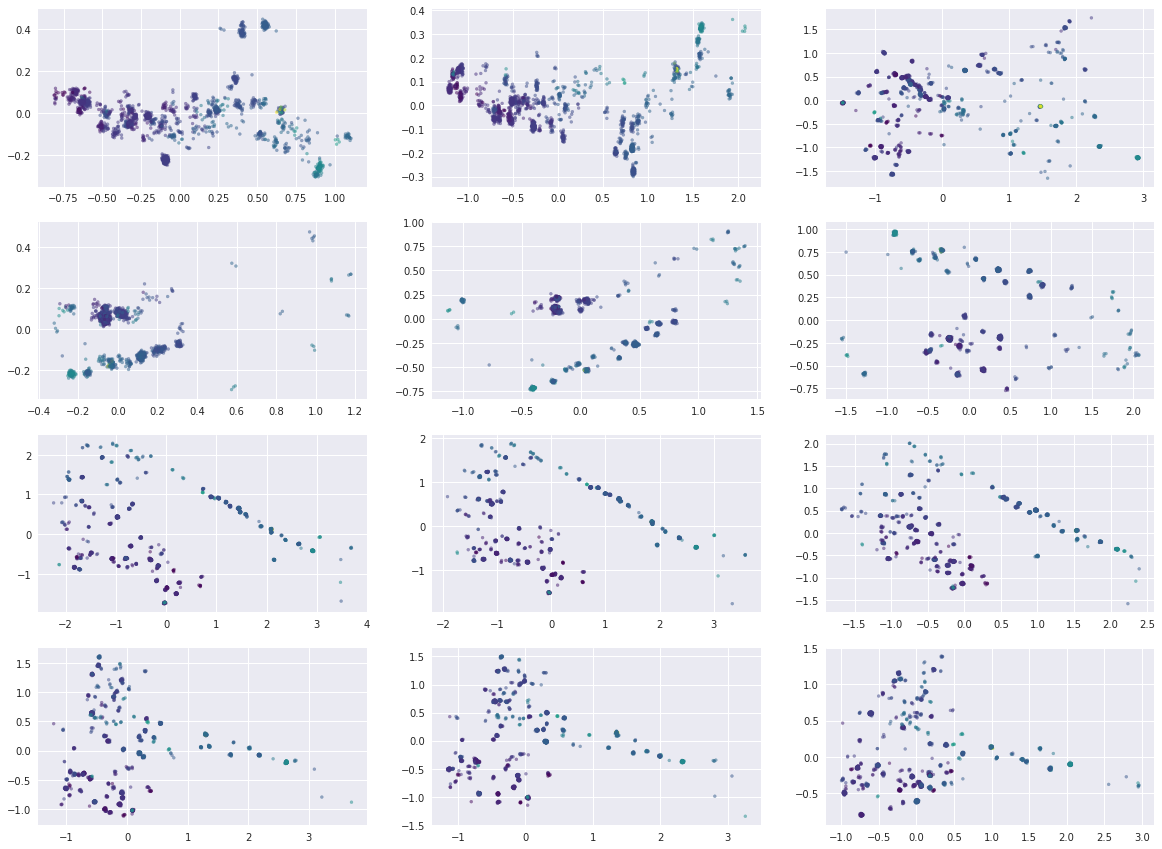

In [14]:
#figure
fig, axs = plt.subplots(4,3, figsize=(20,15))
axs = axs.ravel()

latent_embeddings= np.load('cpt_latent_embeddings.npy')
index = 0
for model in range(12):
    z = latent_embeddings[index, :, :]
    pca = PCA(n_components=2)
    pcs = pca.fit_transform(z)
           
    axs[index].scatter(pcs[:, 0], pcs[:, 1], c=(Y_train),
            alpha=.5, s=3**2, cmap='viridis')
    index += 1

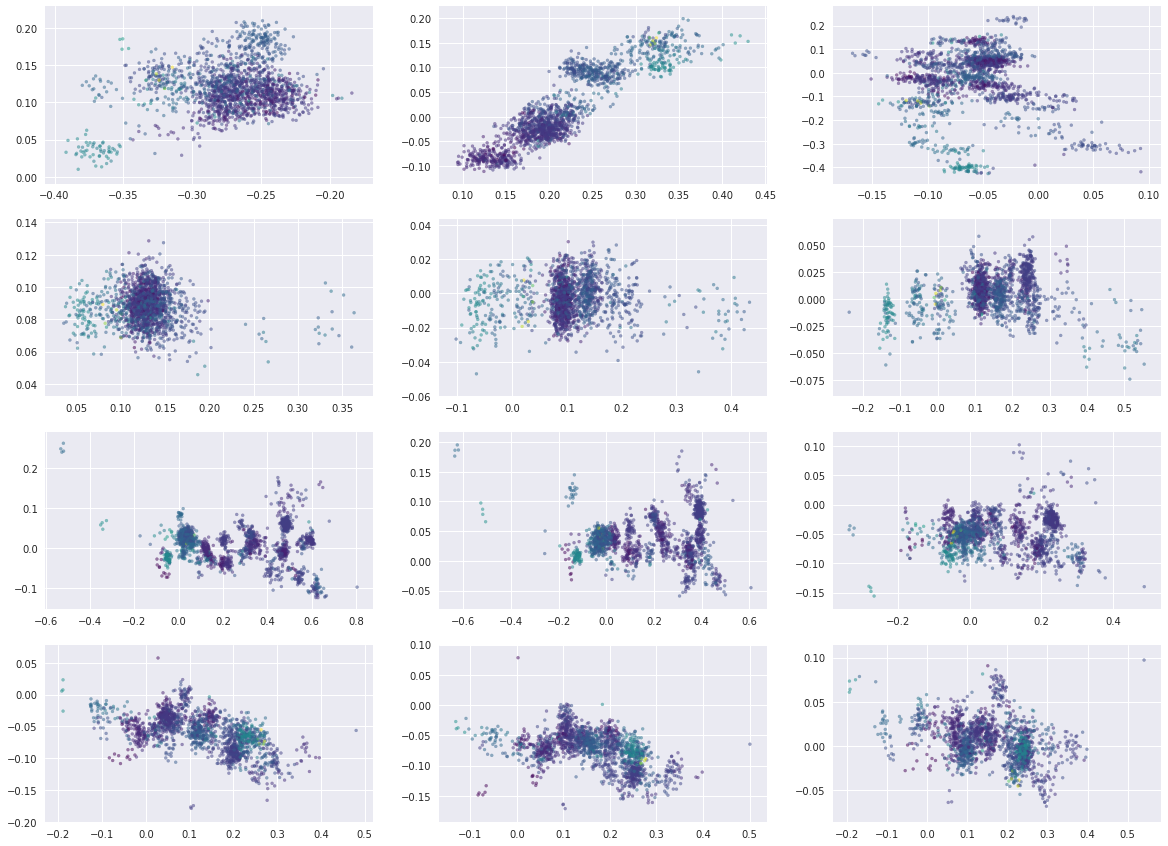

In [15]:
#figure
fig, axs = plt.subplots(4,3, figsize=(20,15))
axs = axs.ravel()

latent_embeddings= np.load('cpt_latent_embeddings.npy')
index = 0
for model in range(12):
    z = latent_embeddings[index, :, :]
    pca = PCA(n_components=2)
    pcs = pca.fit_transform(z)
    axs[index].scatter(z[:, 0], z[:, 1], c=(Y_train),
            alpha=.5, s=3**2, cmap='viridis')
    index += 1

# Viscosity Models

In [16]:
properties = ['viscosity']
T = [297, 316] # select state variable ranges according to manuscript
P = [99, 102] # we will set MD simulation to 101 kPa and 298 K
props = properties
devmodel = salty.aggregate_data(props, T=T, P=P, merge='Union')
devmodel.Data['smiles_string'] = devmodel.Data['smiles-cation'] + "." + devmodel.Data['smiles-anion']
salts = devmodel.Data['smiles_string']
salts = salts.reset_index(drop=True)
print(salts.shape)

(3277,)


In [17]:
values = salts
print(values[0])
print(values.iloc[-1])
print(len(values))
padded_smiles =  [pad_smiles(i, smile_max_length) for i in values if pad_smiles(i, smile_max_length)]
X_train = np.zeros((values.shape[0], smile_max_length, chars_in_dict), dtype=np.float32)
Y_train = np.array(devmodel.Data['Viscosity, Pa&#8226;s'])
for i, smile in enumerate(padded_smiles):
    for j, char in enumerate(smile):
        X_train[i, j, char_to_index[char]] = 1

CCCC[n+]1ccc(cc1)C.[B-](F)(F)(F)F
C1=C[N+](CCCC)=CN1C.C(C(F)(F)F)(C(F)(F)S(=O)(=O)[O-])F
3277


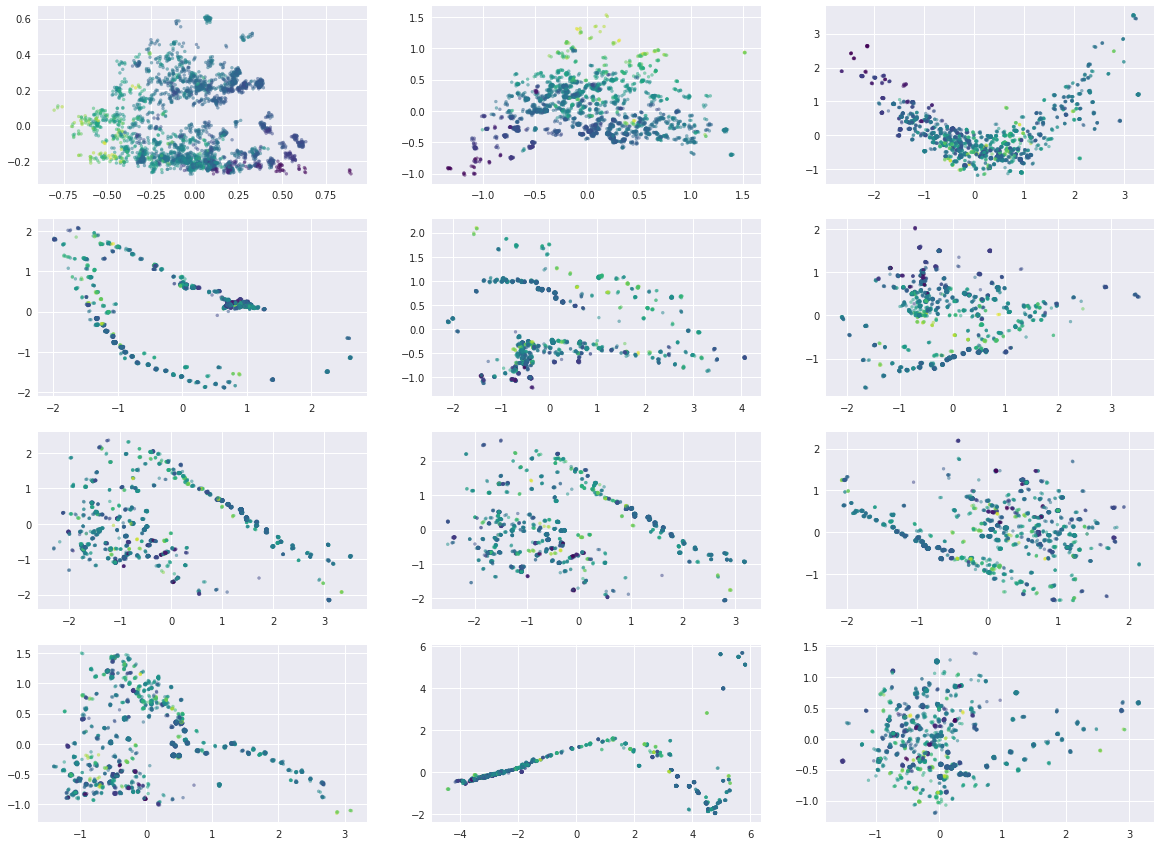

In [18]:
#figure
fig, axs = plt.subplots(4,3, figsize=(20,15))
axs = axs.ravel()

latent_embeddings= np.load('viscosity_latent_embeddings.npy')
index = 0
for model in range(12):
    z = latent_embeddings[index, :, :]
    pca = PCA(n_components=2)
    pcs = pca.fit_transform(z)
           
    axs[index].scatter(pcs[:, 0], pcs[:, 1], c=(Y_train),
            alpha=.5, s=3**2, cmap='viridis')
    index += 1

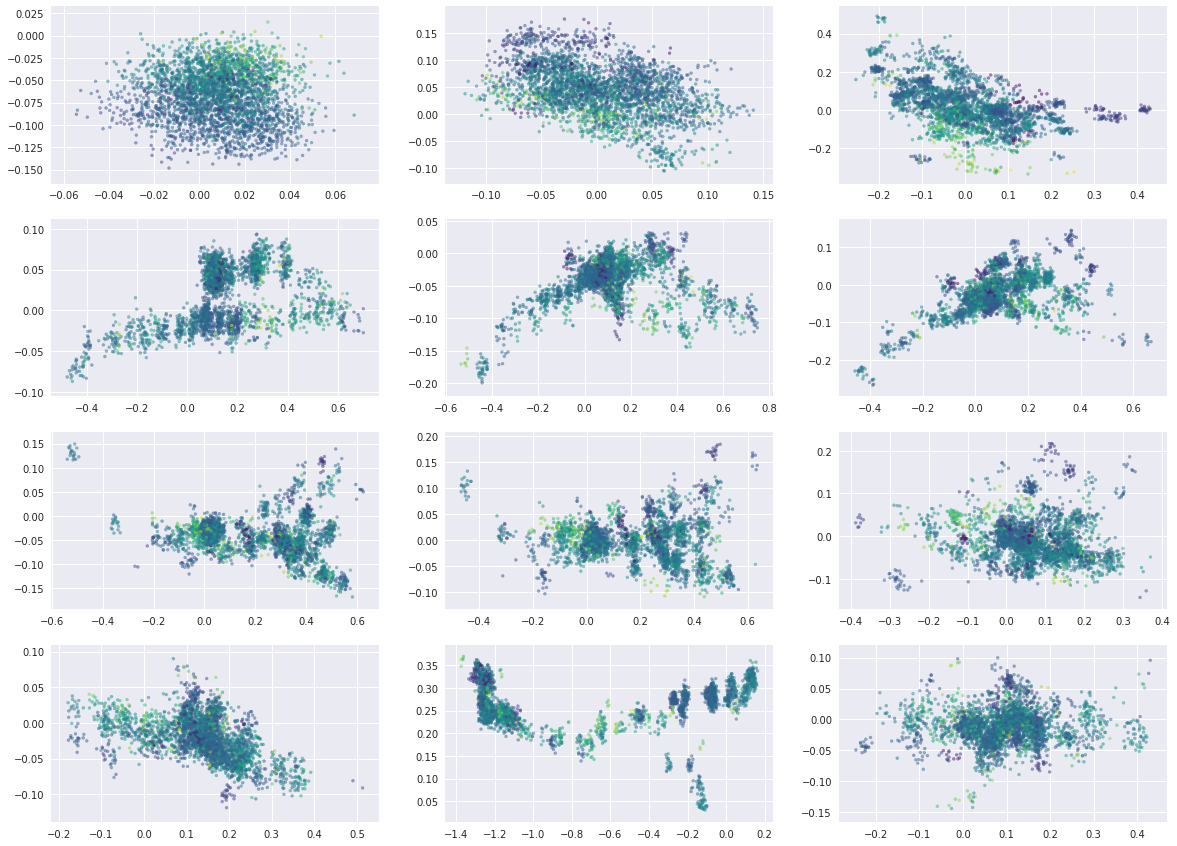

In [19]:
#figure
fig, axs = plt.subplots(4,3, figsize=(20,15))
axs = axs.ravel()

latent_embeddings= np.load('viscosity_latent_embeddings.npy')
index = 0
for model in range(12):
    z = latent_embeddings[index, :, :]
    pca = PCA(n_components=2)
    pcs = pca.fit_transform(z)
    axs[index].scatter(z[:, 0], z[:, 1], c=(Y_train),
            alpha=.5, s=3**2, cmap='viridis')
    index += 1

# Thermal Conductivity

In [20]:
properties = ['thermal_conductivity']
T = [297, 316] # select state variable ranges according to manuscript
P = [99, 102] # we will set MD simulation to 101 kPa and 298 K
props = properties
devmodel = salty.aggregate_data(props, T=T, P=P, merge='Union')
devmodel.Data['smiles_string'] = devmodel.Data['smiles-cation'] + "." + devmodel.Data['smiles-anion']
salts = devmodel.Data['smiles_string']
salts = salts.reset_index(drop=True)
print(salts.shape)

(148,)


In [21]:
values = salts
print(values[0])
print(values.iloc[-1])
print(len(values))
padded_smiles =  [pad_smiles(i, smile_max_length) for i in values if pad_smiles(i, smile_max_length)]
X_train = np.zeros((values.shape[0], smile_max_length, chars_in_dict), dtype=np.float32)
Y_train = np.array(devmodel.Data['Thermal conductivity, W/m/K'])
for i, smile in enumerate(padded_smiles):
    for j, char in enumerate(smile):
        X_train[i, j, char_to_index[char]] = 1

CCCCCCCCn1cc[n+](c1)C.[B-](F)(F)(F)F
CCn1cc[n+](c1)C.COP(=O)([O-])
148


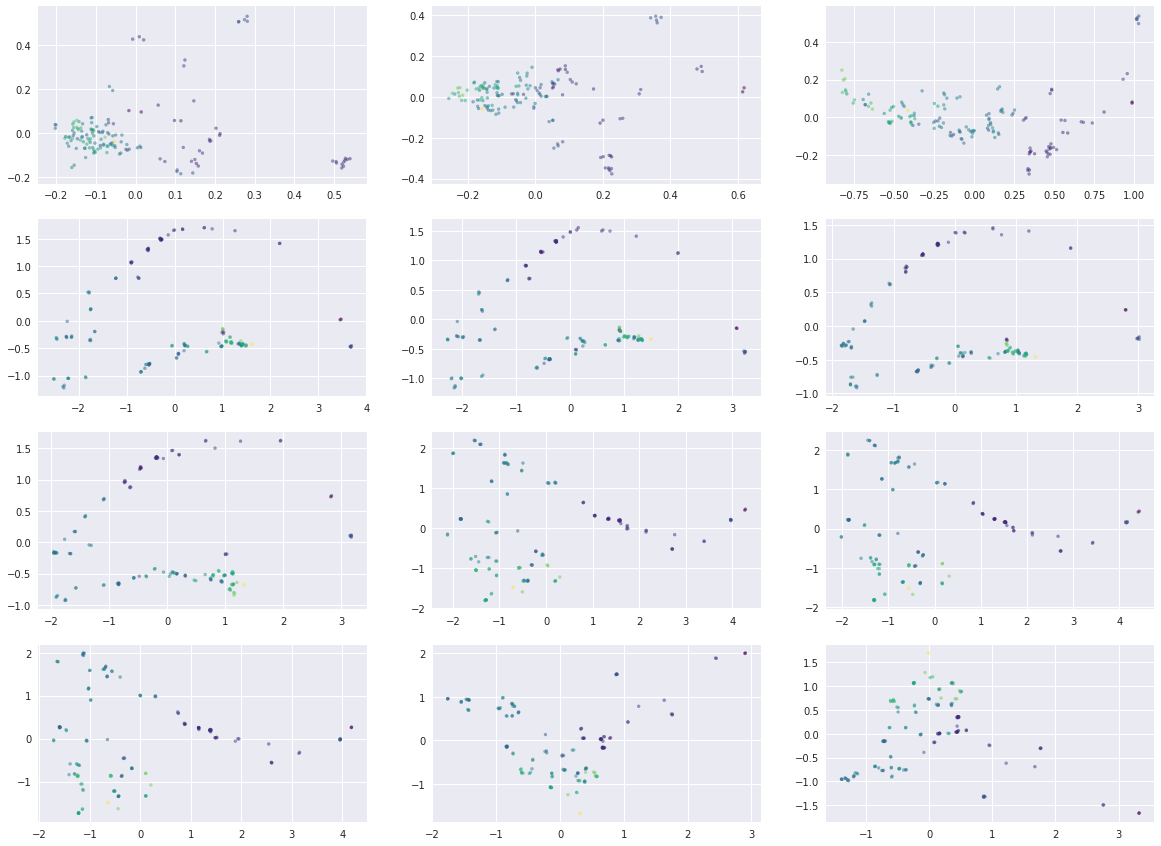

In [22]:
#figure
fig, axs = plt.subplots(4,3, figsize=(20,15))
axs = axs.ravel()

latent_embeddings= np.load('thermal_latent_embeddings.npy')
index = 0
for model in range(12):
    z = latent_embeddings[index, :, :]
    pca = PCA(n_components=2)
    pcs = pca.fit_transform(z)
           
    axs[index].scatter(pcs[:, 0], pcs[:, 1], c=np.exp(Y_train),
            alpha=.5, s=3**2, cmap='viridis')
    index += 1

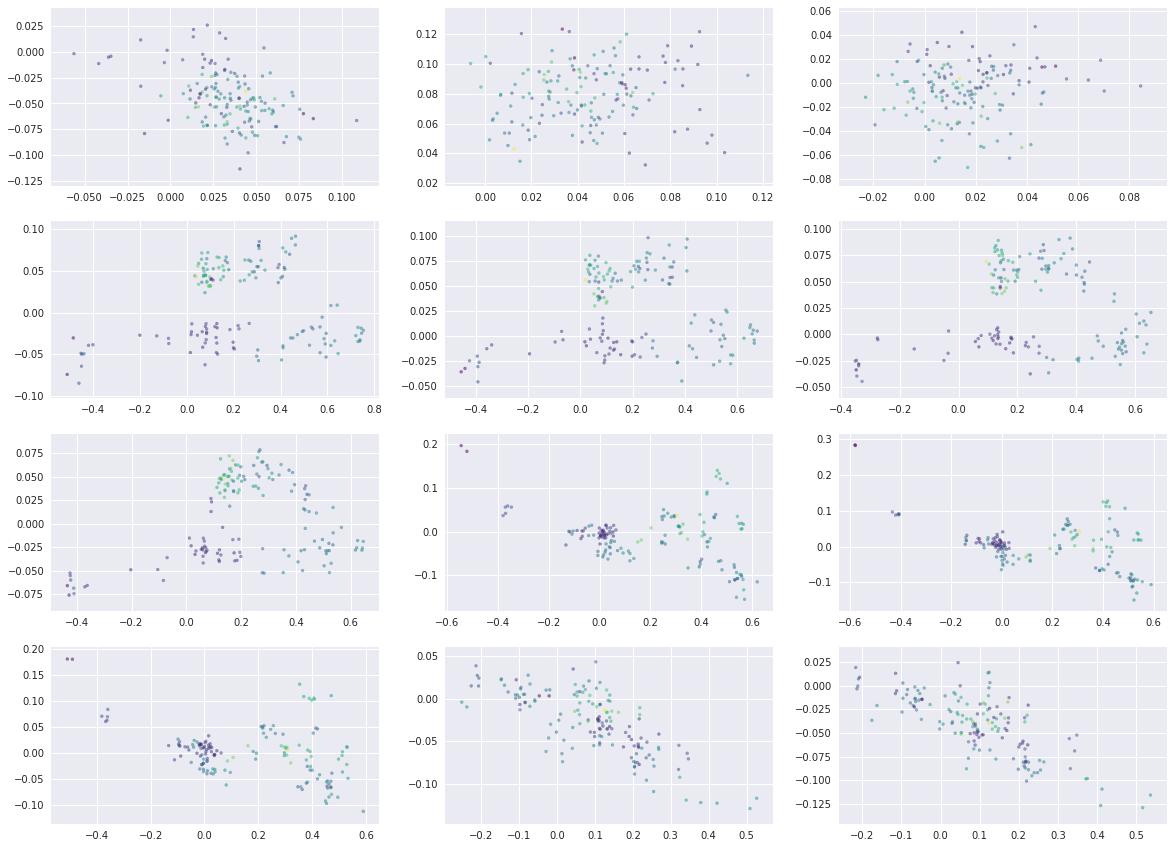

In [23]:
#figure
fig, axs = plt.subplots(4,3, figsize=(20,15))
axs = axs.ravel()

latent_embeddings= np.load('thermal_latent_embeddings.npy')
index = 0
for model in range(12):
    z = latent_embeddings[index, :, :]
    pca = PCA(n_components=2)
    pcs = pca.fit_transform(z)
    axs[index].scatter(z[:, 0], z[:, 1], c=np.exp(Y_train),
            alpha=.5, s=3**2, cmap='viridis')
    index += 1

# Melting Point

In [24]:
properties = ['melting_point']
T = [297, 316] # select state variable ranges according to manuscript
P = [99, 102] # we will set MD simulation to 101 kPa and 298 K
props = properties
devmodel = salty.aggregate_data(props, merge='Union')
devmodel.Data['smiles_string'] = devmodel.Data['smiles-cation'] + "." + devmodel.Data['smiles-anion']
salts = devmodel.Data['smiles_string']
salts = salts.reset_index(drop=True)
print(salts.shape)

(389,)


In [25]:
values = salts
print(values[0])
print(values.iloc[-1])
print(len(values))
padded_smiles =  [pad_smiles(i, smile_max_length) for i in values if pad_smiles(i, smile_max_length)]
X_train = np.zeros((values.shape[0], smile_max_length, chars_in_dict), dtype=np.float32)
Y_train = np.array(devmodel.Data['Normal melting temperature, K'])
for i, smile in enumerate(padded_smiles):
    for j, char in enumerate(smile):
        X_train[i, j, char_to_index[char]] = 1

CCCC[n+]1ccc(cc1)C.[B-](F)(F)(F)F
CN(C)C(=[NH2+])N(C)C.C(=O)(C(F)(F)F)[O-]
389


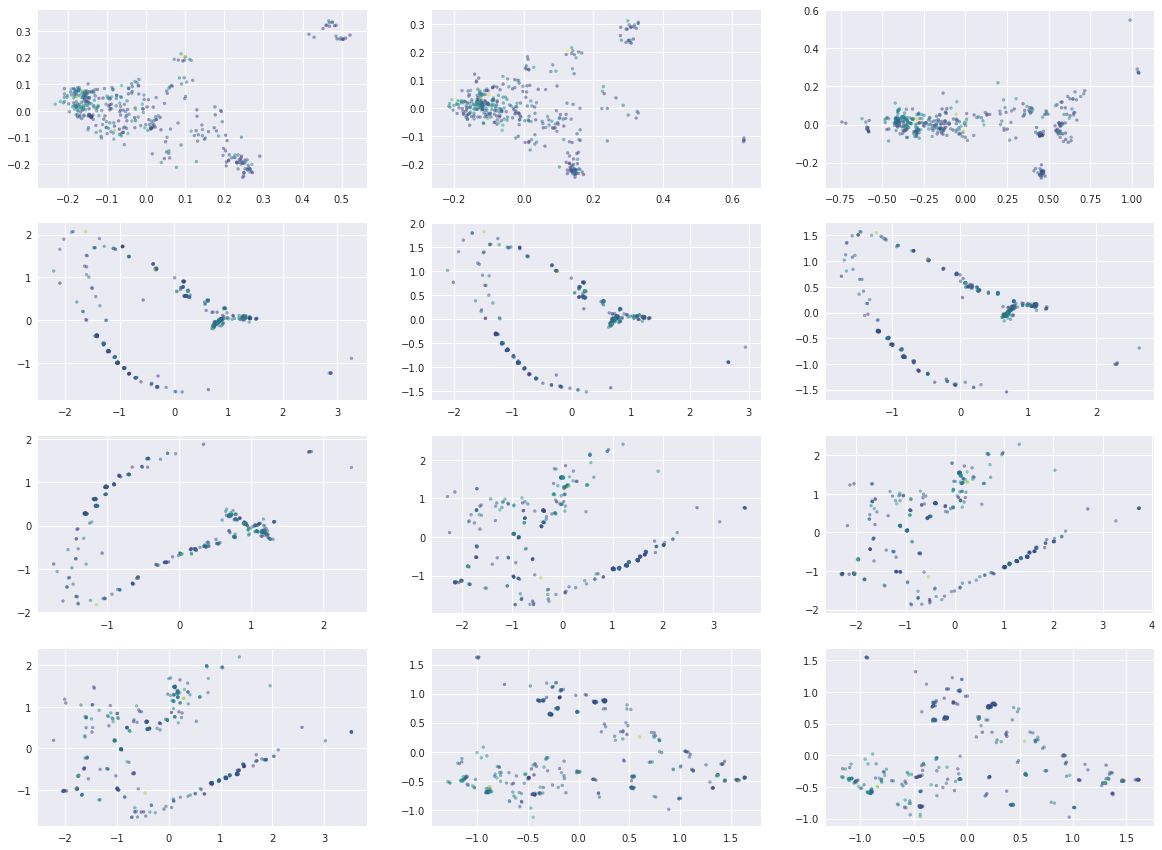

In [26]:
#figure
fig, axs = plt.subplots(4,3, figsize=(20,15))
axs = axs.ravel()

latent_embeddings= np.load('melting_latent_embeddings.npy')
index = 0
for model in range(12):
    z = latent_embeddings[index, :, :]
    pca = PCA(n_components=2)
    pcs = pca.fit_transform(z)
           
    axs[index].scatter(pcs[:, 0], pcs[:, 1], c=(Y_train),
            alpha=.5, s=3**2, cmap='viridis')
    index += 1

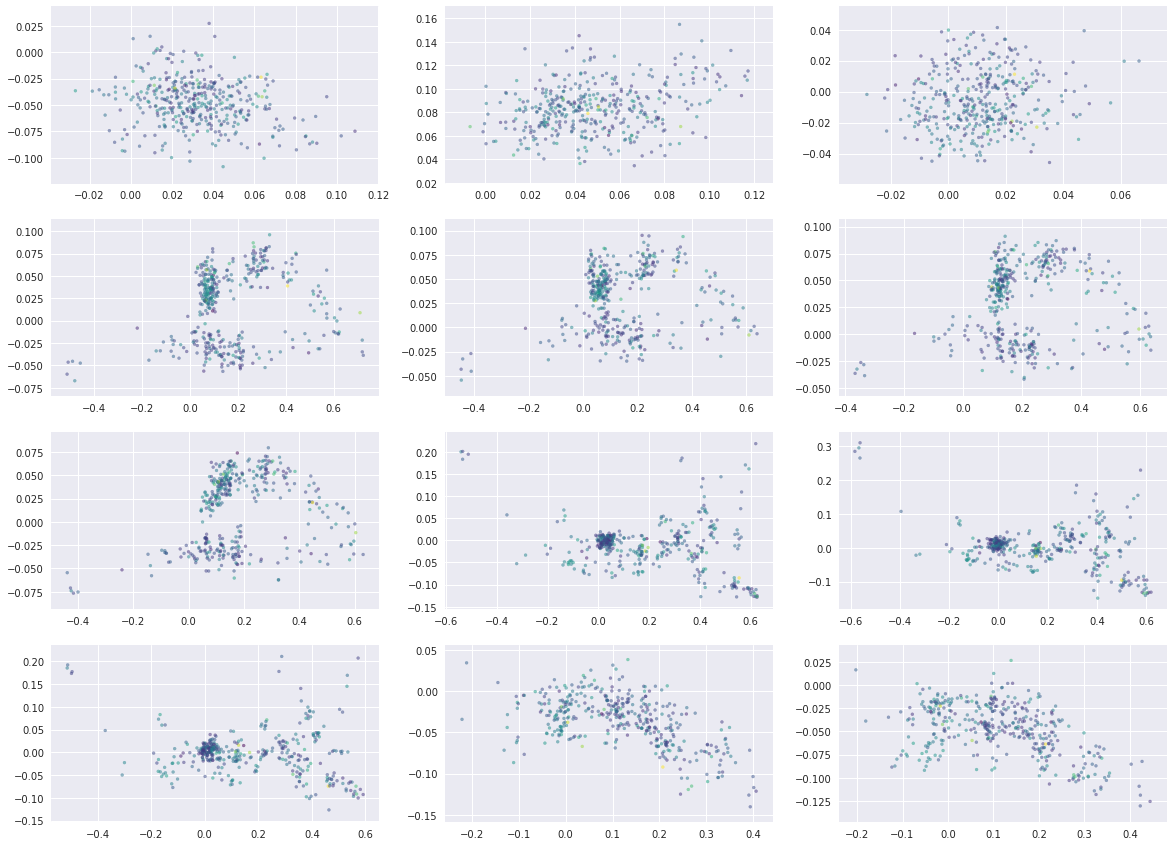

In [27]:
#figure
fig, axs = plt.subplots(4,3, figsize=(20,15))
axs = axs.ravel()

latent_embeddings= np.load('melting_latent_embeddings.npy')
index = 0
for model in range(12):
    z = latent_embeddings[index, :, :]
    pca = PCA(n_components=2)
    pcs = pca.fit_transform(z)
    axs[index].scatter(z[:, 0], z[:, 1], c=(Y_train),
            alpha=.5, s=3**2, cmap='viridis')
    index += 1